In [1]:
# https://nsidc.org/data/smap_l1_l3_anc_static/versions/1
import numpy as np
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
import os
from datetime import datetime
import glob
from tqdm import tqdm

# Configuration

In [50]:
data_dir = r"G:\Araki\SMSigxSMAP\1_data"
SMAPL3_dir = "SPL3SMP"
datarods_dir = "datarods"
SMAPL4_dir = "SPL4SMGP"
SMAPL4_grid_dir = "SMAPL4SMGP_EASEreference"
PET_dir = "PET"
fn = os.path.join(data_dir, r"SPL3SMP\SMAP_L3_SM_P_20150331_R18290_001.h5")

In [3]:
out_dir = os.path.join(data_dir, 'SPL3SMP_datarods')
if ~os.path.exists(out_dir):
    os.makedirs(out_dir)

# Investigate netCDF4 file

In [4]:
ncf = netCDF4.Dataset(fn, diskless=True, persist=False)
nch_am = ncf.groups.get('Soil_Moisture_Retrieval_Data_AM')
nch_pm = ncf.groups.get('Soil_Moisture_Retrieval_Data_PM')

In [5]:
nch_am.variables

{'EASE_column_index': <class 'netCDF4._netCDF4.Variable'>
 uint16 EASE_column_index(phony_dim_0, phony_dim_1)
     long_name: The column index of the 36 km EASE grid cell that contains the associated data.
     coordinates: /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Retrieval_Data_AM/longitude
     valid_min: 0
     valid_max: 963
     _FillValue: 65534
 path = /Soil_Moisture_Retrieval_Data_AM
 unlimited dimensions: 
 current shape = (406, 964)
 filling off,
 'EASE_row_index': <class 'netCDF4._netCDF4.Variable'>
 uint16 EASE_row_index(phony_dim_0, phony_dim_1)
     long_name: The row index of the 36 km EASE grid cell that contains the associated data.
     coordinates: /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Retrieval_Data_AM/longitude
     valid_min: 0
     valid_max: 405
     _FillValue: 65534
 path = /Soil_Moisture_Retrieval_Data_AM
 unlimited dimensions: 
 current shape = (406, 964)
 filling off,
 'albedo': <class 'netCDF4._netCDF4.Variable'>
 float32

In [6]:
nch_pm.variables

{'EASE_column_index_pm': <class 'netCDF4._netCDF4.Variable'>
 uint16 EASE_column_index_pm(phony_dim_3, phony_dim_4)
     long_name: The column index of the 36 km EASE grid cell that contains the associated data.
     coordinates: /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Retrieval_Data_AM/longitude
     valid_min: 0
     valid_max: 963
     _FillValue: 65534
 path = /Soil_Moisture_Retrieval_Data_PM
 unlimited dimensions: 
 current shape = (406, 964)
 filling off,
 'EASE_row_index_pm': <class 'netCDF4._netCDF4.Variable'>
 uint16 EASE_row_index_pm(phony_dim_3, phony_dim_4)
     long_name: The row index of the 36 km EASE grid cell that contains the associated data.
     coordinates: /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Retrieval_Data_AM/longitude
     valid_min: 0
     valid_max: 405
     _FillValue: 65534
 path = /Soil_Moisture_Retrieval_Data_PM
 unlimited dimensions: 
 current shape = (406, 964)
 filling off,
 'albedo_dca_pm': <class 'netCDF4._netCDF4.

# Prepare geocoordinate matrix 

In [7]:
# Return as regular numpy array rather than masked array
_latitude = ma.getdata(nch_am.variables['latitude'][:].filled(fill_value=np.nan), subok=True)
_longitude = ma.getdata(nch_am.variables['longitude'][:].filled(fill_value=np.nan), subok=True)
_EASE_column_index = ma.getdata(nch_am.variables['EASE_column_index'][:].astype(int).filled(fill_value=-1), subok=True)
_EASE_row_index = ma.getdata(nch_am.variables['EASE_row_index'][:].astype(int).filled(fill_value=-1), subok=True)

In [8]:
# Coordinates with no data are skipped --- fill them
latitude = np.nanmax(_latitude, axis=1)
EASE_row_index = np.nanmax(_EASE_row_index, axis=1)
longitude = np.nanmax(_longitude, axis=0)
EASE_column_index = np.nanmax(_EASE_column_index, axis=0)

In [9]:
coord_info_column = pd.DataFrame({"latitude":latitude, "EASE_column_index":EASE_row_index})
coord_info_row = pd.DataFrame({"longitude":longitude, "EASE_row_index":EASE_column_index})
coord_info_column.to_csv(os.path.join(out_dir, 'coord_info_unique_column.csv'), index=False)
coord_info_row.to_csv(os.path.join(out_dir, 'coord_info_unique_row.csv'),  index=False)
coord_info = coord_info_row.assign(key=1).merge(coord_info_column.assign(key=1), on='key').drop('key', axis=1)
coord_info.index.name = 'id'
coord_info.to_csv(os.path.join(out_dir, 'coord_info.csv'))

# Read SMAP L3 data
Refer to this https://github.com/RY4GIT/SMSigxSMAP/blob/master/2_code_to_analyze/test_area_sample_dask_x_xarray.ipynb

In [10]:
def preprocess_SMAPL3(SMAPL3_file_paths):
    # Assign missing time dimension
    # Doesn't care about hour amd minutes, as it is daily data
    xds_am = xr.open_dataset(SMAPL3_file_paths, engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable=['soil_moisture','retrieval_qual_flag','surface_flag'])
    xds_pm = xr.open_dataset(SMAPL3_file_paths, engine='rasterio', group='Soil_Moisture_Retrieval_Data_PM', variable=['soil_moisture_pm','retrieval_qual_flag_pm','surface_flag_pm'])
    ds = xds_pm.merge(xds_am)
    time = datetime.strptime(xds_am.Metadata_Extent_rangeBeginningDateTime.split("T")[0], '%Y-%m-%d')
    ds = ds.assign_coords(time=time)
    return ds

In [ ]:
# Get a list of files 
SMAPL3_fn_pattern = f'SMAP_L3_SM_P_*.h5'
SMAPL3_file_paths = glob.glob(rf'{data_dir}/{SMAPL3_dir}/{SMAPL3_fn_pattern}')

# Load dataset
print("LOADING SMAPL3 data from h5 file")
_ds_SMAPL3_list = []
for filename in tqdm(SMAPL3_file_paths):
    try:
        _ds_SMAPL3 = preprocess_SMAPL3(filename)
        _ds_SMAPL3_list.append(_ds_SMAPL3)
    except Exception as e:
        print(f"An error occurred: {e}")
        continue
_ds_SMAPL3_list_stacked = xr.concat(_ds_SMAPL3_list, dim='time')
# Cannot use open_mfdataset --- it doesn't like h5 file

In [14]:
_ds_SMAPL3_list_stacked

<xarray.Dataset>
Dimensions:                                                 (band: 1,
                                                             time: 2637,
                                                             y: 406, x: 964)
Coordinates:
  * band                                                    (band) int32 1
    spatial_ref                                             int32 0
  * time                                                    (time) datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    Soil_Moisture_Retrieval_Data_PM_retrieval_qual_flag_pm  (time, band, y, x) float32 ...
    Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm        (time, band, y, x) float32 ...
    Soil_Moisture_Retrieval_Data_PM_surface_flag_pm         (time, band, y, x) float32 ...
    Soil_Moisture_Retrieval_Data_AM_retrieval_qual_flag     (time, band, y, x) float32 ...
    Soil_Moisture_Retrieval_Data_AM_soil_moisture           (time, band, y, x) float32 ...
    Soil_Moisture_Retrieval_Data_AM_surface_flag            (time, band, y, x) float32 ...
Attributes: (12/698)
    Metadata_AcquisitionInformation_platformDocument_edition:                ...
    Metadata_AcquisitionInformation_platformDocument_publicationDate:        ...
    Metadata_AcquisitionInformation_platformDocument_title:                  ...
    Metadata_AcquisitionInformation_platform_antennaRotationRate:            ...
    Metadata_AcquisitionInformation_platform_description:                    ...
    Metadata_AcquisitionInformation_platform_identifier:                     ...
    ...                                                                          ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_coordinates: ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_long_name:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_units:       ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_valid_max:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm_valid_min:   ...
    Soil_Moisture_Retrieval_Data_PM_vegetation_water_content_pm__FillValue:  ...

In [34]:
# Create and save the datarods  
out_dir = os.path.join(data_dir, datarods_dir, SMAPL3_dir)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

from itertools import product
print("CREATING SMAPL3 DATARODS")
for y_i, x_j in tqdm(product(EASE_row_index, EASE_column_index)):
    try:
        df_SMAPL3 = _ds_SMAPL3_list_stacked.isel(x=x_j, y=y_i,band=0).to_dataframe().drop(['band', 'spatial_ref'], axis=1)
        filename = f'SPL3SMP_{y_i:03}_{x_j:03}.csv'
        df_SMAPL3.to_csv(os.path.join(out_dir, filename))
    except Exception as e:
        print(f"An error occurred: {e}")
        continue

CREATING SMAPL3 DATARODS


100907it [24:23, 68.95it/s]


KeyboardInterrupt: 

In [91]:
ds_SMAPL3_coord_template = _ds_SMAPL3.assign_coords({'x':longitude, 'y':latitude}).rio.write_crs("epsg:4326")

# Process SMAP L4 precip data

## Read SMAP L4 data

In [52]:
def preprocess_SMAPL4(ds):
    # Assign missing time dimension
    startTime = datetime.strptime(ds.rangeBeginningDateTime.split(".")[0], '%Y-%m-%dT%H:%M:%S')
    endTime = datetime.strptime(ds.rangeEndingDateTime.split(".")[0], '%Y-%m-%dT%H:%M:%S')
    midTime = startTime + (startTime - endTime)/2
    ds = ds.assign_coords(time=midTime)
    return ds

In [ ]:
chunks = {'x': 1200, 'y': 1200, 'time':1, 'band':1}
SMAPL4_fn_pattern = f'SMAP_L4_SM_gph_201610*.nc'
SMAPL4_file_paths = glob.glob(rf'{data_dir}/{SMAPL4_dir}/{SMAPL4_fn_pattern}')
# file_path = r"G:\Araki\SMSigxSMAP\1_data\SPL4SMGP\SMAP_L4_SM_gph_20150331T013000_Vv7032_001_HEGOUT.nc"
# ds_SMAPL4_3hrly = xr.open_mfdataset(file_path, group='Geophysical_Data', engine="rasterio", preprocess=preprocess_SMAPL4, chunks=chunks)
# ds_SMAPL4_3hrly
# ds_SMAPL4_3hrly = xr.open_mfdataset(SMAPL4_file_paths, group='Geophysical_Data', engine="rasterio", preprocess=preprocess_SMAPL4, chunks=chunks)

In [66]:
# Get a list of files 
# Load dataset
_ds_SMAPL4_list = []
for filename in tqdm(SMAPL4_file_paths):
    try:
        _ds_SMAPL4 = xr.open_dataset(filename, group='Geophysical_Data', engine="rasterio")
        _ds_SMAPL4 = preprocess_SMAPL4(_ds_SMAPL4)
        _ds_SMAPL4_list.append(_ds_SMAPL4)
    except Exception as e:
        print(f"An error occurred: {e}")
        continue
_ds_SMAPL4_list_stacked = xr.concat(_ds_SMAPL4_list, dim='time')
# Cannot use open_mfdataset --- can't skip if there is error

  0%|          | 0/248 [00:00<?, ?it/s]c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore
c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The iden

In [129]:
# Re-assign x and y coordinates
SMAPL4_template_fn = r"G:\Araki\SMSigxSMAP\1_data\SPL4SMGP\SMAP_L4_SM_gph_20180911T103000_Vv7032_001_HEGOUT.nc"
SMAPL4_template = xr.open_dataset(SMAPL4_template_fn)
ds_SMAPL4_3hrly = _ds_SMAPL4_list_stacked.assign_coords(x=SMAPL4_template['x'][:], y=SMAPL4_template['y'][:]*(-1))

# Fill values 
_FillValue = 3.4028235e+38 # ds_SMAPL4_3hrly.precipitation_total_surface_flux._FillValue
ds_SMAPL4_3hrly = ds_SMAPL4_3hrly.where(ds_SMAPL4_3hrly.precipitation_total_surface_flux != _FillValue, np.nan)

# Resample to daily
ds_SMAPL4 = ds_SMAPL4_3hrly.resample(time='D', skipna=True, keep_attrs=True).mean()

## Resample to SMAPL3 grid

In [133]:
ds_SMAPL4.rio.write_crs('epsg:4326', inplace=True)
ds_SAMPL4_resampled = ds_SMAPL4.sel(band=1).rio.reproject_match(ds_SMAPL3_coord_template.sel(band=1))
ds_SAMPL4_resampled

c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\xarray\core\common.py:936: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


<xarray.Dataset>
Dimensions:                           (time: 32, band: 1, y: 1822, x: 3856)
Coordinates:
  * band                              (band) int32 1
  * x                                 (x) float64 -180.0 -179.9 ... 179.9 180.0
  * y                                 (y) float64 -85.0 -84.9 ... 84.92 85.01
    projection_information            int32 0
  * time                              (time) datetime64[ns] 2016-09-30 ... 20...
    spatial_ref                       int32 0
Data variables:
    precipitation_total_surface_flux  (time, band, y, x) float32 nan nan ... nan
Attributes: (12/201)
    antennaRotationRate:                13
    description:                        The observation-corrected surface met...
    identifier:                         GEOS5COR
    edition:                            JPL CL#14-2285, JPL 400-1567
    publicationDate:                    2014-07-01
    title:                              SMAP Handbook
    ...                                 ...
    grid_rows:                          1822
    History:                            File written by ldas2daac.x
    Institution:                        NASA Global Modeling and Assimilation...
    References:                         see SMAP L4_SM Product Specification ...
    Source:                             v17.11.1
    Title:                              SMAP L4_SM Geophysical (GPH) Data Gra...

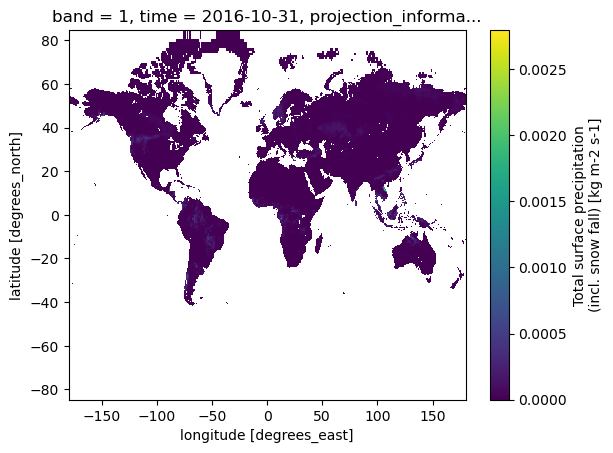

In [145]:
ds_SAMPL4_resampled.precipitation_total_surface_flux.sel(time="2016-10-31").plot()

In [163]:
# Can combine all data together --- but memory is not enough
# combined_ds = _ds_SMAPL3_list_stacked.sel(band=1)
# combined_ds["precipitation_total_surface_flux"] = ds_SAMPL4_resampled.precipitation_total_surface_flux

## Create datarods

In [ ]:
# Create and save the datarods  
out_dir = os.path.join(data_dir, datarods_dir, SMAPL4_dir)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

from itertools import product
print("CREATING SMAPL4 DATARODS")
for y_i, x_j in tqdm(product(EASE_row_index, EASE_column_index)):
    try:
        df_SMAPL3 = ds_SAMPL4_resampled.isel(x=x_j, y=y_i,band=0).to_dataframe().drop(['band', 'spatial_ref', 'projection_information'], axis=1)
        filename = f'{SMAPL4_dir}_{y_i:03}_{x_j:03}.csv'
        df_SMAPL3.to_csv(os.path.join(out_dir, filename))
    except Exception as e:
        print(f"An error occurred: {e}")
        continue

# Process PET data

## Read PET data

In [176]:
PET_fn_pattern = f'*_daily_pet.nc'
PET_file_paths = glob.glob(rf'{data_dir}/{PET_dir}/{PET_fn_pattern}')

# Get a list of files 
# Load dataset
_PET_list = []
for filename in tqdm(PET_file_paths):
    try:
        _ds_PET = xr.open_dataset(filename)
        _PET_list.append(_ds_PET)
    except Exception as e:
        print(f"An error occurred: {e}")
        continue
_PET_list_stacked = xr.concat(_PET_list, dim='time')
# Cannot use open_mfdataset --- it doesn't like h5 file

# # Load data
# ds_PET = xr.open_mfdataset(PET_file_paths, combine="nested", concat_dim="time", parallel=True)
# ds_PET['pet']

100%|██████████| 7/7 [00:00<00:00, 92.11it/s]


MemoryError: Unable to allocate 8.82 GiB for an array with shape (365, 1801, 3600) and data type float32

## Resample PET data

In [169]:
ds_PET.rio.write_crs('epsg:4326', inplace=True)
ds_PET['pet'] = ds_PET.pet.resample(time='D', skipna=True, keep_attrs=True).mean('time')

c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\xarray\core\common.py:936: UserWarning: Passing ``keep_attrs`` to ``resample`` has no effect and will raise an error in xarray 0.20. Pass ``keep_attrs`` directly to the applied function, e.g. ``resample(...).mean(keep_attrs=True)``.
  warnings.warn(


In [ ]:
ds_PET = ds_PET.rename({'latitude': 'y', 'longitude': 'x'})
ds_PET

In [173]:
ds_PET

<xarray.Dataset>
Dimensions:      (time: 2557, y: 1801, x: 3600)
Coordinates:
  * time         (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2021-12-31
  * y            (y) float32 90.0 89.9 89.8 89.7 ... -89.7 -89.8 -89.9 -90.0
  * x            (x) float32 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
    spatial_ref  int32 0
Data variables:
    pet          (time, y, x) float32 dask.array<chunksize=(1, 1801, 3600), meta=np.ndarray>

In [ ]:
ds_SMAPL3_coord_template

In [174]:
ds_PET_resampled = ds_PET.rio.reproject_match(ds_SMAPL3_coord_template.sel(band=1))
ds_PET_resampled
# PET_resampled = ds_PET['pet'].interp(coords={'x': _ds_SMAPL3['x'], 'y': _ds_SMAPL3['y']}, method='linear', kwargs={'fill_value': np.nan})

MemoryError: Unable to allocate 24.7 MiB for an array with shape (1, 1801, 3600) and data type float32

In [ ]:
ds_PET_resampled.pet.sel(time='2015-01-01').plot()

## Create datarods

In [ ]:
# Create and save the datarods  
out_dir = os.path.join(data_dir, datarods_dir, PET_dir)
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

from itertools import product
print("CREATING PET DATARODS")
for y_i, x_j in tqdm(product(EASE_row_index, EASE_column_index)):
    try:
        df_SMAPL3 = ds_SMAPL4.isel(x=x_j, y=y_i,band=0).to_dataframe().drop(['band', 'spatial_ref'], axis=1)
        filename = f'PET_{y_i:03}_{x_j:03}.csv'
        df_SMAPL3.to_csv(os.path.join(out_dir, filename))
    except Exception as e:
        print(f"An error occurred: {e}")
        continue

# Concat all the dataframe

In [ ]:
ds_SMAPL3['soil_moisture_am_masked'] = ds_SMAPL3.soil_moisture.where((ds_SMAPL3.retrieval_qual_flag == 0) | (ds_SMAPL3.retrieval_qual_flag == 8))
ds_SMAPL3['soil_moisture_pm_masked'] = ds_SMAPL3.soil_moisture_pm.where((ds_SMAPL3.retrieval_qual_flag_pm == 0) | (ds_SMAPL3.retrieval_qual_flag_pm == 8))
stacked_data = ds_SMAPL3[['soil_moisture_am_masked', 'soil_moisture_pm_masked']].to_array(dim='new_dim')
ds_SMAPL3['soil_moisture_daily'] = stacked_data.mean(skipna=True, dim="new_dim")

# Read landcover dataset (have different dimensions from other data)

c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\rasterio\__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
c:\Users\raraki8159\.conda\envs\SMAP_v2\Lib\site-packages\rioxarray\_io.py:1111: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


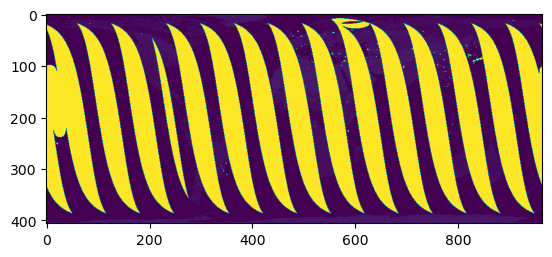

In [139]:
xds_am = xr.open_dataset(fn, engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable='landcover_class')
xds_am = xds_am.rename({'band': 'x', 'x':'band'})
xds_am = xds_am.transpose('band', 'y', 'x')
xds_am
IGBPclass_am = xds_am.Soil_Moisture_Retrieval_Data_AM_landcover_class[0].values.transpose()

xds_pm = xr.open_dataset(fn, engine='rasterio', group='Soil_Moisture_Retrieval_Data_PM', variable='landcover_class_pm')
# In a weird format, need to change coordinate name and transpose
xds_pm = xds_pm.rename({'band': 'x', 'x':'band'})
xds_pm = xds_pm.transpose('band', 'y', 'x')
# Read the most dominant landcover, index=0
IGBPclass_pm = xds_pm.Soil_Moisture_Retrieval_Data_PM_landcover_class_pm[0].values.transpose()